# Milestone 1

### Importing Needed Libraries

In [36]:
import pdfplumber 
import fitz 
import os 
import re 
import json 
import pandas as pd
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
import nlp
from wordcloud import WordCloud
from collections import Counter
from langchain.text_splitter import RecursiveCharacterTextSplitter
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20100\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20100\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Connecting the code with the files in PDF folder in the repo

In [37]:
pdf_dir = 'PDF files/'
pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]

### Defining function for Extraction , Preprocessing , tokenizing and removing stop words

In [38]:
#Text Extraction
def extract_text (pdf_path ):
    text = ''
    doc = fitz.open(pdf_path)
    for page in doc:
        text += page.get_text("text") + "\n"
    return text.strip()

#Cleaning and removing noise
def clean_text(text):
    # Remove extra spaces and new lines, but keep punctuation like periods and question marks
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9.?! ]', '', text)  # Keep important punctuation
    return text.lower().strip()

def chunk_text(text, chunk_size=500, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,  # Max characters per chunk
        chunk_overlap=chunk_overlap,  # Overlap for context continuity
        length_function=len,  # Measure length by characters
        separators=["\n\n", "\n", ".", " ", ""]  # Hierarchical splitting
    )
    return text_splitter.split_text(text) 

# Tokenizing the text into sentences
def tokenize_text(text):
    return [s.strip() for s in sent_tokenize(text) if s.strip()]


#removing stop words in each sentence
def removing_stopwords(sentences):
    stop_words = set(stopwords.words('english'))
    filtered_sentences = []

    for sentence in sentences:
        words = word_tokenize(sentence)  
        filtered_words = [word for word in words if word.lower() not in stop_words]  
        filtered_sentences.append(' '.join(filtered_words))  

    return filtered_sentences

### Listing all availabe uploaded PDF files and the user will input the number of file he wants 
### Note : will be changed later so the user can upload his own pdf file

In [39]:
print('\n📂 Available PDFs:')
for i, pdf in enumerate(pdf_files,1):
    print(f'{i} : {pdf}')
choice = int(input("\nEnter the number of the PDF you want to extract text from: ")) - 1
if 0 <= choice < len(pdf_files):
    PDF_FILE = pdf_files[choice]
    PDF_PATH = os.path.join(pdf_dir, PDF_FILE)
    print(f"\n✅ Extracting text from: {PDF_FILE}")
    text = extract_text(PDF_PATH)
    print(f'\n {text}')



📂 Available PDFs:
1 : 05. A Short History of Egypt – to About 1970 author Aerospace Computing Lab.pdf
2 : ArtOfWar.pdf
3 : oldmansea.pdf
4 : Process Control Instrumentation Technology 8th Ed.pdf.pdf
5 : Python for Data Analysis_ Data Wrangling with Pandas, NumPy, and IPython ( PDFDrive ).pdf

✅ Extracting text from: Process Control Instrumentation Technology 8th Ed.pdf.pdf

 Process Control Instrumentation
Technology
Curtis D. Johnson
Eighth Edition

Process Control Instrumentation
Technology
Curtis D. Johnson
Eighth Edition

Pearson Education Limited
Edinburgh Gate
Harlow
Essex CM20 2JE
England and Associated Companies throughout the world
Visit us on the World Wide Web at: www.pearsoned.co.uk
© Pearson Education Limited 2014 
All rights reserved. No part of this publication may be reproduced, stored in a retrieval system, or transmitted 
in any form or by any means, electronic, mechanical, photocopying, recording or otherwise, without either the 
prior written permission of the publ

### Preprocessing the text

In [40]:
cleaned_text = clean_text(text)
tokenized_text = tokenize_text(cleaned_text)
filtered_text = ' '.join(removing_stopwords(tokenized_text))
chunks = chunk_text(cleaned_text)


### Basic Statistics

In [41]:
words = word_tokenize(filtered_text)

total_words = len(words)
unique_words = len(set(words))
total_sent = len(tokenized_text)
print("\n📊 Basic Text Statistics:")
print(f"🔹 Total Words: {total_words}")
print(f"🔹 Unique Words: {unique_words}")
print(f"🔹 Total Sentences: {total_sent}")


📊 Basic Text Statistics:
🔹 Total Words: 127416
🔹 Unique Words: 11606
🔹 Total Sentences: 8418


## Visualization Time

### Most frequent 20 word

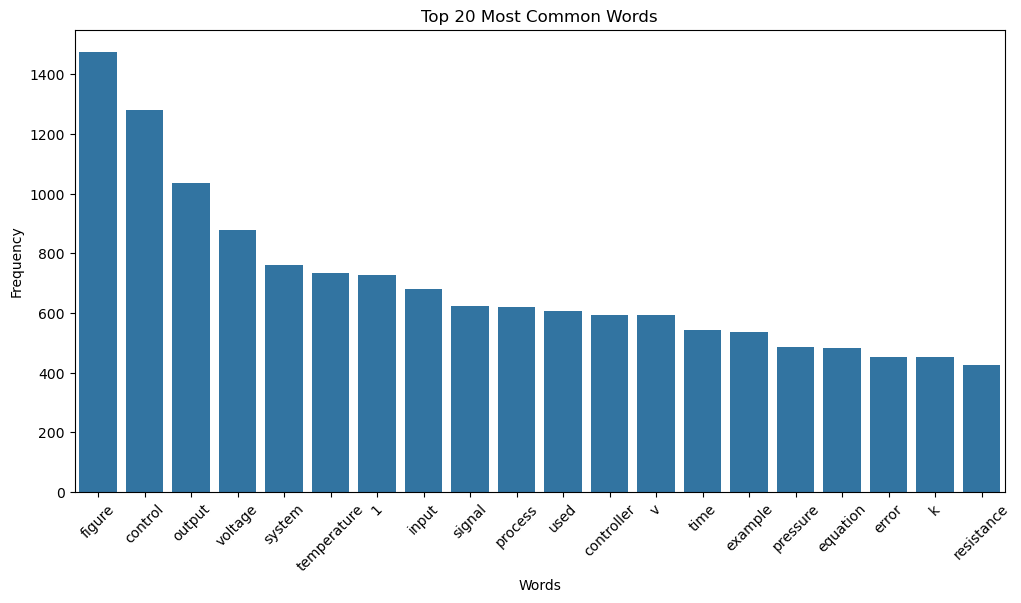

In [42]:
words = [word.lower() for word in words if word.isalnum()]  
words_count = Counter(words)
most_common_words = words_count.most_common(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, _ in most_common_words], y=[count for _, count in most_common_words])
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Common Words")
plt.show()

### WordCloud

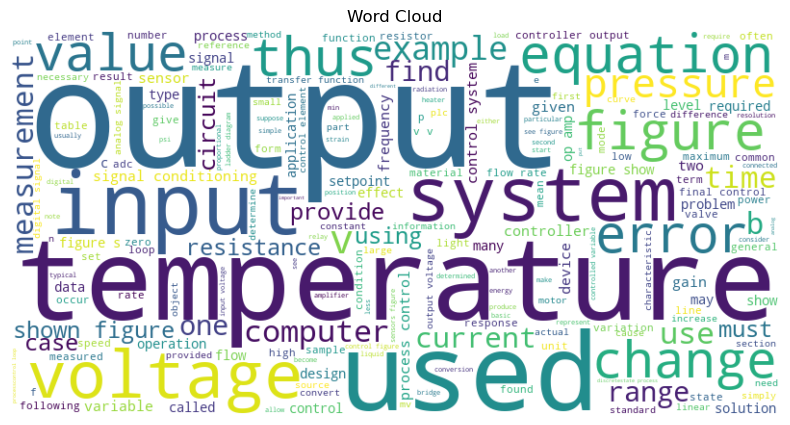

In [43]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

## Saving extracted text into .json file

In [44]:
def save_to_json(data,filename):
    if not os.path.exists('Extracted text'):
        os.makedirs('Extracted text')
    
    file_path = os.path.join('Extracted text', filename)  
    with open(file_path, "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)
    
    print(f"✅ Filtered text saved as {file_path}")

In [45]:
save_to_json(filtered_text, 'Art of War') #Example 

✅ Filtered text saved as Extracted text\Art of War


# Milestone 2

### importing the needed libraries SentenceTransformer and faiss ###

In [46]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

### Choosing the embedding model ###

In [47]:
def generate_embeddings(chunks, model_name='all-MiniLM-L6-v2', batch_size=32):
    """
    Generate embeddings for text chunks using SentenceTransformer.
    """
    model = SentenceTransformer(model_name)
    embeddings = []
    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_numpy=True, show_progress_bar=True)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings), model

# Creating FAISS Index

After generating embeddings for the sentences, we use FAISS (Facebook AI Similarity Search) to create an index that stores these embeddings. The index allows for fast similarity searches using the L2 (Euclidean) distance metric.

In [48]:
def setup_faiss_index(embeddings, index_file='faiss_index.bin'):
    """
    Set up a FAISS index for storing embeddings and save it to disk.
    """
    try:
        dimension = embeddings.shape[1]
        index = faiss.IndexFlatL2(dimension)  # L2 distance for similarity search
        index.add(embeddings)
        faiss.write_index(index, index_file)
        print(f"✅ FAISS index saved to {index_file}")
        return index
    except Exception as e:
        print(f"Error setting up FAISS index: {e}")
        return None

In [49]:
index_file = f'faiss_index_{PDF_FILE}.bin'
embeddings, model = generate_embeddings(chunks)
faiss_index = setup_faiss_index(embeddings, index_file)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ FAISS index saved to faiss_index_Process Control Instrumentation Technology 8th Ed.pdf.pdf.bin


# Performing the Search

For a given query, we generate its embedding using the SentenceTransformer model and search for the most similar sentences in the FAISS index. The top-k most relevant sentences are then returned.

In [50]:
def search_similar_faiss(query, chunks, index, model, top_k=5, threshold=1.0):
    query_embedding = model.encode([query], convert_to_numpy=True)
    D, I = index.search(query_embedding, top_k)  # D: distances, I: indices
    results = [(chunks[i], D[0][j]) for j, i in enumerate(I[0]) if D[0][j] <= threshold]
    return results

# Query Preprocessing

The user's query is processed in the same way as the document text: cleaned, tokenized, and stopwords are removed. This ensures that the query is in the same format as the sentences stored in the index.

In [51]:
def preprocess_query(query):
    # Clean and remove stop words from the query, similar to your text preprocessing
    cleaned_query = clean_text(query)
    tokenized_query = tokenize_text(cleaned_query)
    filtered_query = ' '.join(removing_stopwords(tokenized_query))
    return filtered_query

# User Query Input

The user enters a search query, which is then processed and used to retrieve the most relevant sentences from the document.

In [52]:
test_query = input("\nEnter a test query (e.g., 'What is the art of war about?'): ")
print("\n🔍 Top relevant chunks:")
results = search_similar_faiss(test_query, chunks, faiss_index, model, top_k=5)
for i, (chunk, distance) in enumerate(results, 1):
    print(f"Chunk {i}: {chunk[:100]}... (L2 Distance: {distance:.4f})")



🔍 Top relevant chunks:
Chunk 1: . 1 introduction human progress from a primitive state to our present complex technological world ha... (L2 Distance: 0.6511)
Chunk 2: . cascade control a control system composed of two loops where the setpoint of one loop the in ner l... (L2 Distance: 0.8122)
Chunk 3: . when automatic control is applied to systems like the one in figure 3 which are designed to regula... (L2 Distance: 0.8197)
Chunk 4: . 2.1 processcontrol principles in process control the basic objective is to regulate the value of s... (L2 Distance: 0.8296)
Chunk 5: . 1. process control itself has been described as suitable for application to any situation in which... (L2 Distance: 0.8313)
